In [ ]:
# 形態素分析ライブラリーMeCab と 辞書(mecab-ipadic-NEologd)のインストール 
# !apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab > /dev/null
# !git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git > /dev/null 
# !echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n > /dev/null 2>&1
# !pip install mecab-python3 > /dev/null

# シンボリックリンクによるエラー回避
# !ln -s /etc/mecabrc /usr/local/etc/mecabrc
# 辞書のパス
# path = "-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd"


# pytorchのバージョン指定
!pip uninstall torch torchvision torchaudio
!pip install torchtext==0.8.1

# ライブラリのインストール
!pip install janome
!pip install japanize-matplotlib

Found existing installation: torch 1.10.0+cu111
Uninstalling torch-1.10.0+cu111:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.7/dist-packages/caffe2/*
    /usr/local/lib/python3.7/dist-packages/torch-1.10.0+cu111.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torch/*
Proceed (y/n)? y
  Successfully uninstalled torch-1.10.0+cu111
Found existing installation: torchvision 0.11.1+cu111
Uninstalling torchvision-0.11.1+cu111:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/torchvision-0.11.1+cu111.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libcudart.7be20469.so.11.0
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libjpeg.ceea7512.so.62
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libnvjpeg.8313e8da.so.11
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libpng16.7f72a3c5.so.16
    /usr/local/lib/pyth

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
from collections import Counter
# import MeCab
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import spacy

from gensim.corpora import Dictionary
from gensim import matutils 
from glob import glob
from janome.tokenizer import Tokenizer
from sklearn.model_selection import train_test_split
from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Pipeline
from torch.nn.utils.rnn import pack_padded_sequence
from tqdm import tqdm

import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import pdb
import re

from warnings import simplefilter
simplefilter('ignore', FutureWarning)
import gc
import japanize_matplotlib
japanize_matplotlib.japanize()

root = "/content/drive/MyDrive/データ分析/dl4e/"

# デバイスを取得
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: {0}".format(DEVICE))

# mecab
# mecab = MeCab.Tagger("-Owakati")

Device: cuda


In [ ]:
data = pd.read_csv(root+"input/house_price.csv")

# lgb_predicts_train = pd.read_csv(root+"input/lgb_predicts_train.csv")
# lgb_predicts_test = pd.read_csv(root+"input/lgb_predicts_test.csv")

In [ ]:
data.head(1)

,Unnamed: 0,others,target,others_add_features,others_add_features_list
0,0,バストイレ別、バルコニー、エアコン、ガスコンロ対応、クロゼット、浴室乾燥機、オートロック、室...,114000.0,バストイレ別、バルコニー、エアコン、ガスコンロ対応、クロゼット、浴室乾燥機、オートロック、室...,"['バストイレ別', 'バルコニー', 'エアコン', 'ガスコンロ対応', 'クロゼット'..."


In [ ]:
# data = data[(data["target"] >= 60000) & (data["target"] <= 120000)]

In [ ]:
train, valid = train_test_split(
    data[["others", "target"]],
    test_size=0.25, 
    shuffle=True, 
    random_state=42, 
   )

# train = train.reset_index(drop=True)
# valid = valid.reset_index(drop=True)

# train["target"] = train["target"] - lgb_predicts_train["predict"]
# valid["target"] = valid["target"] - lgb_predicts_test["predict"]


train.to_csv(root+"output/house_price_train_othres_nomi.csv", index=False, header=None)
valid.to_csv(root+"output/house_price_valid_othres_nomi.csv", index=False, header=None)
# del train, valid, temp

In [ ]:
train.head()

,others,target
2395,バストイレ別、バルコニー、エアコン、ガスコンロ対応、クロゼット、フローリング、TVインターホ...,98000.0
2029,バストイレ別、バルコニー、エアコン、クロゼット、フローリング、浴室乾燥機、オートロック、室内...,81000.0
314,バストイレ別、バルコニー、エアコン、ガスコンロ対応、クロゼット、フローリング、TVインターホ...,98000.0
4129,バストイレ別、バルコニー、エアコン、ガスコンロ対応、フローリング、室内洗濯置、シューズボック...,81000.0
2378,エアコン、フローリング、室内洗濯置、角住戸、電気コンロ、単身者相談、冷蔵庫、敷金1ヶ月、仲手...,59000.0


In [ ]:
def tokenizer(text):
    return [t for t in text.split("、")]

In [ ]:
# 各種Fieldを定義
TEXT = Field(
    sequential=True, 
    tokenize=tokenizer, 
    # lower=True, 
    include_lengths=True, 
    # preprocessing=pipe, 
    # stop_words=rm
    )

# LABEL = LabelField(dtype=torch.float)
LABEL = Field(sequential=False, use_vocab=False, dtype=torch.float)


train, val = TabularDataset.splits(
    path=root+"output/", 
    train="house_price_train_othres_nomi.csv", 
    validation="house_price_valid_othres_nomi.csv",
    format="csv",
    fields=[("text", TEXT), ("label", LABEL)]
)

# 単語に番号を振る
# 最低出現回数をmin_freqで指定
TEXT.build_vocab(train, min_freq=2)
LABEL.build_vocab(train)

# イテレータの作成
batch_size = 256
train_iter, val_iter = BucketIterator.splits(
    (train, val), batch_size=batch_size, device=DEVICE,
    sort=False
)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warn

In [ ]:
class MaillOpenModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, padding_idx):
        super(MaillOpenModel, self).__init__()
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.padding_idx = padding_idx
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.linear1  = nn.Linear(embedding_dim, 32)
        # self.bachnorm1 = nn.BatchNorm1d(32)
        # self.linear2  = nn.Linear(32, output_dim)
        self.linear2  = nn.Linear(32, 16)
        self.linear3 =  nn.Linear(16, output_dim)
        
        # ----- 2値分類の時
        # self.act = nn.Sigmoid()
        # -----

    def forward(self, inputs):
        # inputs = (text, text_length)
        # 入力テキストを取得
        # inputs_text = [sentence lengths, batch_size]
        inputs_text = inputs[0]
        
        # 入力をembeddingする
        # output shape: [sentence lengths, batch_size, embeddding_dim]
        embeds = self.embeddings(inputs_text)
        
        # Embeding Vectorの各次元毎 (dim=0)に和を計算し、文章のベクトルに変換する (Bag-of-Words)
        # output shape: [batch_size, embeddding_dim]
        embeds = torch.sum(embeds, dim=0) # [batch_size, embedding_dim]

        # torch.concat([""])
        
        # embeddingの結果をlinear1に入力し、出力結果に活性化関数reluを適用する
        # output shape: [batch_size, 32]
        output = F.relu(self.linear1(embeds))
        # output = F.relu(self.bachnorm1(self.linear1(embeds)))
        
        # linear1の結果をlinear2に入力する
        # output shape: [batch_size, 16]
        output = F.relu(self.linear2(output)) # [batch_size, output_dim]

        # linear2の結果をlinear3に入力する
        # output shape: [batch_size, output_dim]
        output = self.linear3(output)
        
        # ----- 2値分類のとき
        # 出力をSigmoid関数で変換して、最終出力を得る
        # output shape: [batch_size]
        # output = self.act(output.squeeze(1))
        # -----
        
        return output

In [ ]:
def train_model(model, loss_function, optimizer, num_epochs=20):
    # 学習モードに設定
    model.train()

    # モデルの学習
    for epoch in range(num_epochs):
        train_loss, train_acc = 0.0, 0.0
        for batch in tqdm(train_iter):
            optimizer.zero_grad() # 勾配の初期化
            output = model(batch.text)
            loss = loss_function(output, batch.label.float()) # 損失関数の計算
            train_loss += loss.item()  # 損失の加算
            
            # ----- 2値分類の時
            # acc = (torch.round(output) == batch.label).sum() # 正答数の数え上げ
            # train_acc += acc.item()  # 正答数の加算
            # -----

            loss.backward()  # 勾配の計算(逆伝播)
            optimizer.step()  # パラメータの更新

        avg_train_loss = train_loss / (len(train))  # 平均損失の計算

        # ----- 2値分類の時
        # avg_train_acc = train_acc / (len(train))  # 正答率の計算
        # -----

        print(('Epoch [{}/{}], train_loss: {train_loss:.5f}')
        .format(epoch+1, num_epochs, train_loss=avg_train_loss))
      
    return model

In [ ]:
def evaluation(model):
    # テストデータの予測
    model.eval()  # 推論モードに切替
    mse = nn.MSELoss()
    mae = nn.L1Loss()
    
    # 計算グラフの構築をしないよう設定
    with torch.no_grad(): 
        total = 0
        valid_mse = 0
        valid_mae = 0
        cnt = 0

        for batch in tqdm(val_iter):    
            output = model(batch.text)  # 予測の計算
            valid_mse += mse(output.squeeze(), batch.label) # MSEの計算
            valid_mae += mae(output.squeeze(), batch.label) # MAEの計算
            cnt += 1

        print('\nValid MSE: {:.2f}'.format(valid_mse/cnt))
        print('Valid MAE: {:.2f}'.format(valid_mae/cnt))


In [ ]:
vocab_size = len(TEXT.vocab)
embedding_dim = 16
output_dim = 1
padding_idx = TEXT.vocab.stoi["<pad>"]

# モデル定義
mailopen_model = MaillOpenModel(vocab_size, embedding_dim, output_dim, padding_idx).to(DEVICE)
loss_function = nn.MSELoss().to(DEVICE)
optimizer = optim.Adam(mailopen_model.parameters(), lr=0.005)

# モデルの学習
mailopen_model = train_model(mailopen_model, loss_function, optimizer, num_epochs=500)

# モデルの評価
evaluation(mailopen_model)

  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect 

Epoch [1/500], train_loss: 27834478.89825


100%|██████████| 16/16 [00:00<00:00, 186.97it/s]


Epoch [2/500], train_loss: 27658889.34018


100%|██████████| 16/16 [00:00<00:00, 179.47it/s]


Epoch [3/500], train_loss: 27210791.59712


100%|██████████| 16/16 [00:00<00:00, 165.53it/s]


Epoch [4/500], train_loss: 25404216.04111


100%|██████████| 16/16 [00:00<00:00, 152.30it/s]


Epoch [5/500], train_loss: 20077037.51696


100%|██████████| 16/16 [00:00<00:00, 165.97it/s]


Epoch [6/500], train_loss: 10658729.66906


100%|██████████| 16/16 [00:00<00:00, 176.83it/s]


Epoch [7/500], train_loss: 4666278.98869


100%|██████████| 16/16 [00:00<00:00, 176.79it/s]


Epoch [8/500], train_loss: 4233685.50874


100%|██████████| 16/16 [00:00<00:00, 180.45it/s]


Epoch [9/500], train_loss: 3968593.67729


100%|██████████| 16/16 [00:00<00:00, 158.00it/s]


Epoch [10/500], train_loss: 3768039.39979


100%|██████████| 16/16 [00:00<00:00, 168.59it/s]


Epoch [11/500], train_loss: 3548506.54060


100%|██████████| 16/16 [00:00<00:00, 141.14it/s]


Epoch [12/500], train_loss: 3397967.37513


100%|██████████| 16/16 [00:00<00:00, 142.40it/s]


Epoch [13/500], train_loss: 3266271.17780


100%|██████████| 16/16 [00:00<00:00, 157.39it/s]


Epoch [14/500], train_loss: 3132576.65776


100%|██████████| 16/16 [00:00<00:00, 176.23it/s]


Epoch [15/500], train_loss: 3011868.89209


100%|██████████| 16/16 [00:00<00:00, 191.16it/s]


Epoch [16/500], train_loss: 2926544.26310


100%|██████████| 16/16 [00:00<00:00, 172.10it/s]


Epoch [17/500], train_loss: 2816667.56012


100%|██████████| 16/16 [00:00<00:00, 170.59it/s]


Epoch [18/500], train_loss: 2721241.45529


100%|██████████| 16/16 [00:00<00:00, 165.63it/s]


Epoch [19/500], train_loss: 2653128.53443


100%|██████████| 16/16 [00:00<00:00, 139.33it/s]


Epoch [20/500], train_loss: 2556031.98356


100%|██████████| 16/16 [00:00<00:00, 180.78it/s]


Epoch [21/500], train_loss: 2495977.32374


100%|██████████| 16/16 [00:00<00:00, 181.53it/s]


Epoch [22/500], train_loss: 2488104.50154


100%|██████████| 16/16 [00:00<00:00, 180.71it/s]


Epoch [23/500], train_loss: 2421296.55910


100%|██████████| 16/16 [00:00<00:00, 179.95it/s]


Epoch [24/500], train_loss: 2367388.73587


100%|██████████| 16/16 [00:00<00:00, 172.87it/s]


Epoch [25/500], train_loss: 2354483.61768


100%|██████████| 16/16 [00:00<00:00, 180.95it/s]


Epoch [26/500], train_loss: 2291016.29599


100%|██████████| 16/16 [00:00<00:00, 174.54it/s]


Epoch [27/500], train_loss: 2306299.74101


100%|██████████| 16/16 [00:00<00:00, 176.84it/s]


Epoch [28/500], train_loss: 2292027.37102


100%|██████████| 16/16 [00:00<00:00, 155.96it/s]


Epoch [29/500], train_loss: 2261814.07605


100%|██████████| 16/16 [00:00<00:00, 179.52it/s]


Epoch [30/500], train_loss: 2253832.97020


100%|██████████| 16/16 [00:00<00:00, 167.75it/s]


Epoch [31/500], train_loss: 2224104.75642


100%|██████████| 16/16 [00:00<00:00, 185.67it/s]


Epoch [32/500], train_loss: 2218796.38232


100%|██████████| 16/16 [00:00<00:00, 177.36it/s]


Epoch [33/500], train_loss: 2189398.44604


100%|██████████| 16/16 [00:00<00:00, 164.46it/s]


Epoch [34/500], train_loss: 2183409.60329


100%|██████████| 16/16 [00:00<00:00, 182.32it/s]


Epoch [35/500], train_loss: 2165299.20658


100%|██████████| 16/16 [00:00<00:00, 186.74it/s]


Epoch [36/500], train_loss: 2150338.03905


100%|██████████| 16/16 [00:00<00:00, 165.82it/s]


Epoch [37/500], train_loss: 2125978.63926


100%|██████████| 16/16 [00:00<00:00, 166.87it/s]


Epoch [38/500], train_loss: 2137595.22302


100%|██████████| 16/16 [00:00<00:00, 162.23it/s]


Epoch [39/500], train_loss: 2131581.86228


100%|██████████| 16/16 [00:00<00:00, 183.37it/s]


Epoch [40/500], train_loss: 2111692.59609


100%|██████████| 16/16 [00:00<00:00, 190.42it/s]


Epoch [41/500], train_loss: 2123714.62282


100%|██████████| 16/16 [00:00<00:00, 179.11it/s]


Epoch [42/500], train_loss: 2133563.74923


100%|██████████| 16/16 [00:00<00:00, 170.59it/s]


Epoch [43/500], train_loss: 2116124.35766


100%|██████████| 16/16 [00:00<00:00, 190.19it/s]


Epoch [44/500], train_loss: 2103429.67318


100%|██████████| 16/16 [00:00<00:00, 171.16it/s]


Epoch [45/500], train_loss: 2109331.83145


100%|██████████| 16/16 [00:00<00:00, 162.75it/s]


Epoch [46/500], train_loss: 2143318.57760


100%|██████████| 16/16 [00:00<00:00, 184.28it/s]


Epoch [47/500], train_loss: 2102695.49846


100%|██████████| 16/16 [00:00<00:00, 165.45it/s]


Epoch [48/500], train_loss: 2080702.86536


100%|██████████| 16/16 [00:00<00:00, 159.96it/s]


Epoch [49/500], train_loss: 2081955.29702


100%|██████████| 16/16 [00:00<00:00, 172.34it/s]


Epoch [50/500], train_loss: 2046994.45838


100%|██████████| 16/16 [00:00<00:00, 183.37it/s]


Epoch [51/500], train_loss: 2071984.52621


100%|██████████| 16/16 [00:00<00:00, 173.95it/s]


Epoch [52/500], train_loss: 2052330.70504


100%|██████████| 16/16 [00:00<00:00, 165.22it/s]


Epoch [53/500], train_loss: 2068507.88078


100%|██████████| 16/16 [00:00<00:00, 185.62it/s]


Epoch [54/500], train_loss: 2033957.62384


100%|██████████| 16/16 [00:00<00:00, 174.71it/s]


Epoch [55/500], train_loss: 2019351.70401


100%|██████████| 16/16 [00:00<00:00, 179.49it/s]


Epoch [56/500], train_loss: 2046623.63823


100%|██████████| 16/16 [00:00<00:00, 177.33it/s]


Epoch [57/500], train_loss: 2051916.50565


100%|██████████| 16/16 [00:00<00:00, 142.44it/s]


Epoch [58/500], train_loss: 2044784.53443


100%|██████████| 16/16 [00:00<00:00, 180.14it/s]


Epoch [59/500], train_loss: 2034932.59609


100%|██████████| 16/16 [00:00<00:00, 180.26it/s]


Epoch [60/500], train_loss: 2034664.96197


100%|██████████| 16/16 [00:00<00:00, 175.48it/s]


Epoch [61/500], train_loss: 2033836.39877


100%|██████████| 16/16 [00:00<00:00, 178.97it/s]


Epoch [62/500], train_loss: 2037409.29085


100%|██████████| 16/16 [00:00<00:00, 175.87it/s]


Epoch [63/500], train_loss: 2003109.57451


100%|██████████| 16/16 [00:00<00:00, 181.38it/s]


Epoch [64/500], train_loss: 2025201.87461


100%|██████████| 16/16 [00:00<00:00, 185.94it/s]


Epoch [65/500], train_loss: 2024952.60843


100%|██████████| 16/16 [00:00<00:00, 185.08it/s]


Epoch [66/500], train_loss: 2026108.52210


100%|██████████| 16/16 [00:00<00:00, 173.32it/s]


Epoch [67/500], train_loss: 2008418.69681


100%|██████████| 16/16 [00:00<00:00, 168.40it/s]


Epoch [68/500], train_loss: 2022649.89928


100%|██████████| 16/16 [00:00<00:00, 182.19it/s]


Epoch [69/500], train_loss: 2009994.63926


100%|██████████| 16/16 [00:00<00:00, 156.18it/s]


Epoch [70/500], train_loss: 1989288.47688


100%|██████████| 16/16 [00:00<00:00, 180.26it/s]


Epoch [71/500], train_loss: 1994638.35560


100%|██████████| 16/16 [00:00<00:00, 134.63it/s]


Epoch [72/500], train_loss: 1991646.03494


100%|██████████| 16/16 [00:00<00:00, 172.64it/s]


Epoch [73/500], train_loss: 1980322.50771


100%|██████████| 16/16 [00:00<00:00, 177.65it/s]


Epoch [74/500], train_loss: 1992695.68756


100%|██████████| 16/16 [00:00<00:00, 184.34it/s]


Epoch [75/500], train_loss: 2013293.96095


100%|██████████| 16/16 [00:00<00:00, 169.53it/s]


Epoch [76/500], train_loss: 1976824.30421


100%|██████████| 16/16 [00:00<00:00, 177.36it/s]


Epoch [77/500], train_loss: 1995193.56218


100%|██████████| 16/16 [00:00<00:00, 155.22it/s]


Epoch [78/500], train_loss: 1982954.20349


100%|██████████| 16/16 [00:00<00:00, 180.19it/s]


Epoch [79/500], train_loss: 1988230.02672


100%|██████████| 16/16 [00:00<00:00, 168.61it/s]


Epoch [80/500], train_loss: 1985140.85920


100%|██████████| 16/16 [00:00<00:00, 179.75it/s]


Epoch [81/500], train_loss: 1980213.13052


100%|██████████| 16/16 [00:00<00:00, 170.02it/s]


Epoch [82/500], train_loss: 1946421.35252


100%|██████████| 16/16 [00:00<00:00, 174.89it/s]


Epoch [83/500], train_loss: 1980760.86331


100%|██████████| 16/16 [00:00<00:00, 177.39it/s]


Epoch [84/500], train_loss: 1985824.23844


100%|██████████| 16/16 [00:00<00:00, 185.82it/s]


Epoch [85/500], train_loss: 1971576.37821


100%|██████████| 16/16 [00:00<00:00, 165.86it/s]


Epoch [86/500], train_loss: 1981893.88695


100%|██████████| 16/16 [00:00<00:00, 173.79it/s]


Epoch [87/500], train_loss: 1977710.28160


100%|██████████| 16/16 [00:00<00:00, 153.15it/s]


Epoch [88/500], train_loss: 1996053.92806


100%|██████████| 16/16 [00:00<00:00, 176.00it/s]


Epoch [89/500], train_loss: 1969999.46557


100%|██████████| 16/16 [00:00<00:00, 178.89it/s]


Epoch [90/500], train_loss: 1953429.55807


100%|██████████| 16/16 [00:00<00:00, 169.81it/s]


Epoch [91/500], train_loss: 1974408.77287


100%|██████████| 16/16 [00:00<00:00, 179.97it/s]


Epoch [92/500], train_loss: 1953798.10894


100%|██████████| 16/16 [00:00<00:00, 191.31it/s]


Epoch [93/500], train_loss: 2001568.42754


100%|██████████| 16/16 [00:00<00:00, 176.35it/s]


Epoch [94/500], train_loss: 1968427.71634


100%|██████████| 16/16 [00:00<00:00, 190.79it/s]


Epoch [95/500], train_loss: 1955922.56526


100%|██████████| 16/16 [00:00<00:00, 173.06it/s]


Epoch [96/500], train_loss: 1973656.74820


100%|██████████| 16/16 [00:00<00:00, 172.96it/s]


Epoch [97/500], train_loss: 1964171.46146


100%|██████████| 16/16 [00:00<00:00, 151.00it/s]


Epoch [98/500], train_loss: 1967352.00822


100%|██████████| 16/16 [00:00<00:00, 168.17it/s]


Epoch [99/500], train_loss: 1977336.37821


100%|██████████| 16/16 [00:00<00:00, 169.20it/s]


Epoch [100/500], train_loss: 1952258.78726


100%|██████████| 16/16 [00:00<00:00, 154.56it/s]


Epoch [101/500], train_loss: 1985925.75540


100%|██████████| 16/16 [00:00<00:00, 153.93it/s]


Epoch [102/500], train_loss: 1967261.62384


100%|██████████| 16/16 [00:00<00:00, 153.00it/s]


Epoch [103/500], train_loss: 1967270.33916


100%|██████████| 16/16 [00:00<00:00, 170.84it/s]


Epoch [104/500], train_loss: 1950559.17780


100%|██████████| 16/16 [00:00<00:00, 180.55it/s]


Epoch [105/500], train_loss: 1963519.85200


100%|██████████| 16/16 [00:00<00:00, 180.48it/s]


Epoch [106/500], train_loss: 1954598.40493


100%|██████████| 16/16 [00:00<00:00, 168.11it/s]


Epoch [107/500], train_loss: 1960864.04111


100%|██████████| 16/16 [00:00<00:00, 175.47it/s]


Epoch [108/500], train_loss: 1962992.93731


100%|██████████| 16/16 [00:00<00:00, 175.16it/s]


Epoch [109/500], train_loss: 1942544.80576


100%|██████████| 16/16 [00:00<00:00, 169.26it/s]


Epoch [110/500], train_loss: 1965025.57862


100%|██████████| 16/16 [00:00<00:00, 188.65it/s]


Epoch [111/500], train_loss: 1965363.30524


100%|██████████| 16/16 [00:00<00:00, 178.33it/s]


Epoch [112/500], train_loss: 1953551.44913


100%|██████████| 16/16 [00:00<00:00, 169.29it/s]


Epoch [113/500], train_loss: 1935834.55704


100%|██████████| 16/16 [00:00<00:00, 159.99it/s]


Epoch [114/500], train_loss: 1945263.75334


100%|██████████| 16/16 [00:00<00:00, 160.06it/s]


Epoch [115/500], train_loss: 1985760.92086


100%|██████████| 16/16 [00:00<00:00, 176.18it/s]


Epoch [116/500], train_loss: 1922252.53032


100%|██████████| 16/16 [00:00<00:00, 174.62it/s]


Epoch [117/500], train_loss: 1963316.94964


100%|██████████| 16/16 [00:00<00:00, 179.68it/s]


Epoch [118/500], train_loss: 1959035.14902


100%|██████████| 16/16 [00:00<00:00, 182.15it/s]


Epoch [119/500], train_loss: 1942774.53649


100%|██████████| 16/16 [00:00<00:00, 167.51it/s]


Epoch [120/500], train_loss: 1960986.53237


100%|██████████| 16/16 [00:00<00:00, 172.09it/s]


Epoch [121/500], train_loss: 1965391.89311


100%|██████████| 16/16 [00:00<00:00, 192.37it/s]


Epoch [122/500], train_loss: 1947671.31757


100%|██████████| 16/16 [00:00<00:00, 170.98it/s]


Epoch [123/500], train_loss: 1969657.57040


100%|██████████| 16/16 [00:00<00:00, 174.04it/s]


Epoch [124/500], train_loss: 1942659.20658


100%|██████████| 16/16 [00:00<00:00, 175.25it/s]


Epoch [125/500], train_loss: 1937427.24769


100%|██████████| 16/16 [00:00<00:00, 166.98it/s]


Epoch [126/500], train_loss: 1970689.81706


100%|██████████| 16/16 [00:00<00:00, 170.72it/s]


Epoch [127/500], train_loss: 1935112.50976


100%|██████████| 16/16 [00:00<00:00, 150.47it/s]


Epoch [128/500], train_loss: 1923197.04830


100%|██████████| 16/16 [00:00<00:00, 176.99it/s]


Epoch [129/500], train_loss: 1941774.84070


100%|██████████| 16/16 [00:00<00:00, 177.76it/s]


Epoch [130/500], train_loss: 1988295.17780


100%|██████████| 16/16 [00:00<00:00, 172.64it/s]


Epoch [131/500], train_loss: 1934186.43371


100%|██████████| 16/16 [00:00<00:00, 180.82it/s]


Epoch [132/500], train_loss: 1942325.75540


100%|██████████| 16/16 [00:00<00:00, 166.48it/s]


Epoch [133/500], train_loss: 1951030.14183


100%|██████████| 16/16 [00:00<00:00, 183.92it/s]


Epoch [134/500], train_loss: 1914131.17369


100%|██████████| 16/16 [00:00<00:00, 169.89it/s]


Epoch [135/500], train_loss: 1947654.79137


100%|██████████| 16/16 [00:00<00:00, 169.20it/s]


Epoch [136/500], train_loss: 1960063.47379


100%|██████████| 16/16 [00:00<00:00, 183.56it/s]


Epoch [137/500], train_loss: 1953282.96814


100%|██████████| 16/16 [00:00<00:00, 165.67it/s]


Epoch [138/500], train_loss: 1934815.72045


100%|██████████| 16/16 [00:00<00:00, 183.28it/s]


Epoch [139/500], train_loss: 1950935.46557


100%|██████████| 16/16 [00:00<00:00, 183.43it/s]


Epoch [140/500], train_loss: 1966433.06886


100%|██████████| 16/16 [00:00<00:00, 184.03it/s]


Epoch [141/500], train_loss: 1942227.14080


100%|██████████| 16/16 [00:00<00:00, 174.03it/s]


Epoch [142/500], train_loss: 1927140.76053


100%|██████████| 16/16 [00:00<00:00, 176.25it/s]


Epoch [143/500], train_loss: 1951317.44296


100%|██████████| 16/16 [00:00<00:00, 175.94it/s]


Epoch [144/500], train_loss: 1934751.35046


100%|██████████| 16/16 [00:00<00:00, 174.15it/s]


Epoch [145/500], train_loss: 1946424.65776


100%|██████████| 16/16 [00:00<00:00, 159.92it/s]


Epoch [146/500], train_loss: 1956741.96917


100%|██████████| 16/16 [00:00<00:00, 180.11it/s]


Epoch [147/500], train_loss: 1937779.36280


100%|██████████| 16/16 [00:00<00:00, 169.17it/s]


Epoch [148/500], train_loss: 1925694.80781


100%|██████████| 16/16 [00:00<00:00, 185.60it/s]


Epoch [149/500], train_loss: 1927731.55190


100%|██████████| 16/16 [00:00<00:00, 183.76it/s]


Epoch [150/500], train_loss: 1933616.09044


100%|██████████| 16/16 [00:00<00:00, 170.64it/s]


Epoch [151/500], train_loss: 1909390.63515


100%|██████████| 16/16 [00:00<00:00, 176.64it/s]


Epoch [152/500], train_loss: 1946284.74409


100%|██████████| 16/16 [00:00<00:00, 175.53it/s]


Epoch [153/500], train_loss: 1950770.14594


100%|██████████| 16/16 [00:00<00:00, 170.91it/s]


Epoch [154/500], train_loss: 1922028.22610


100%|██████████| 16/16 [00:00<00:00, 187.39it/s]


Epoch [155/500], train_loss: 1944243.42857


100%|██████████| 16/16 [00:00<00:00, 172.73it/s]


Epoch [156/500], train_loss: 1927296.45221


100%|██████████| 16/16 [00:00<00:00, 170.84it/s]


Epoch [157/500], train_loss: 1904880.34532


100%|██████████| 16/16 [00:00<00:00, 166.35it/s]


Epoch [158/500], train_loss: 1937013.79651


100%|██████████| 16/16 [00:00<00:00, 167.20it/s]


Epoch [159/500], train_loss: 1946381.70606


100%|██████████| 16/16 [00:00<00:00, 169.40it/s]


Epoch [160/500], train_loss: 1913195.97122


100%|██████████| 16/16 [00:00<00:00, 168.03it/s]


Epoch [161/500], train_loss: 1921247.74512


100%|██████████| 16/16 [00:00<00:00, 171.87it/s]


Epoch [162/500], train_loss: 1953615.64645


100%|██████████| 16/16 [00:00<00:00, 169.56it/s]


Epoch [163/500], train_loss: 1902757.24563


100%|██████████| 16/16 [00:00<00:00, 159.96it/s]


Epoch [164/500], train_loss: 1924676.20144


100%|██████████| 16/16 [00:00<00:00, 169.88it/s]


Epoch [165/500], train_loss: 1947398.98869


100%|██████████| 16/16 [00:00<00:00, 183.70it/s]


Epoch [166/500], train_loss: 1908137.47996


100%|██████████| 16/16 [00:00<00:00, 162.22it/s]


Epoch [167/500], train_loss: 1907185.67729


100%|██████████| 16/16 [00:00<00:00, 178.57it/s]


Epoch [168/500], train_loss: 1917071.01336


100%|██████████| 16/16 [00:00<00:00, 175.00it/s]


Epoch [169/500], train_loss: 1917161.84995


100%|██████████| 16/16 [00:00<00:00, 163.05it/s]


Epoch [170/500], train_loss: 1938640.32066


100%|██████████| 16/16 [00:00<00:00, 153.62it/s]


Epoch [171/500], train_loss: 1939504.51799


100%|██████████| 16/16 [00:00<00:00, 173.65it/s]


Epoch [172/500], train_loss: 1929535.36691


100%|██████████| 16/16 [00:00<00:00, 142.24it/s]


Epoch [173/500], train_loss: 1926774.19116


100%|██████████| 16/16 [00:00<00:00, 140.13it/s]


Epoch [174/500], train_loss: 1948651.30524


100%|██████████| 16/16 [00:00<00:00, 174.10it/s]


Epoch [175/500], train_loss: 1935787.96300


100%|██████████| 16/16 [00:00<00:00, 174.58it/s]


Epoch [176/500], train_loss: 1904165.03186


100%|██████████| 16/16 [00:00<00:00, 177.35it/s]


Epoch [177/500], train_loss: 1952669.28674


100%|██████████| 16/16 [00:00<00:00, 167.07it/s]


Epoch [178/500], train_loss: 1918618.68037


100%|██████████| 16/16 [00:00<00:00, 179.50it/s]


Epoch [179/500], train_loss: 1935031.50668


100%|██████████| 16/16 [00:00<00:00, 160.85it/s]


Epoch [180/500], train_loss: 1955071.92600


100%|██████████| 16/16 [00:00<00:00, 182.59it/s]


Epoch [181/500], train_loss: 1929856.69065


100%|██████████| 16/16 [00:00<00:00, 157.95it/s]


Epoch [182/500], train_loss: 1927283.78212


100%|██████████| 16/16 [00:00<00:00, 155.22it/s]


Epoch [183/500], train_loss: 1917431.66290


100%|██████████| 16/16 [00:00<00:00, 154.59it/s]


Epoch [184/500], train_loss: 1916694.11716


100%|██████████| 16/16 [00:00<00:00, 157.75it/s]


Epoch [185/500], train_loss: 1918522.98458


100%|██████████| 16/16 [00:00<00:00, 154.16it/s]


Epoch [186/500], train_loss: 1926499.32991


100%|██████████| 16/16 [00:00<00:00, 185.81it/s]


Epoch [187/500], train_loss: 1909490.30216


100%|██████████| 16/16 [00:00<00:00, 170.04it/s]


Epoch [188/500], train_loss: 1905061.93628


100%|██████████| 16/16 [00:00<00:00, 189.89it/s]


Epoch [189/500], train_loss: 1906625.02775


100%|██████████| 16/16 [00:00<00:00, 175.23it/s]


Epoch [190/500], train_loss: 1916191.56423


100%|██████████| 16/16 [00:00<00:00, 172.37it/s]


Epoch [191/500], train_loss: 1904941.69784


100%|██████████| 16/16 [00:00<00:00, 160.75it/s]


Epoch [192/500], train_loss: 1923561.43063


100%|██████████| 16/16 [00:00<00:00, 163.65it/s]


Epoch [193/500], train_loss: 1899746.26927


100%|██████████| 16/16 [00:00<00:00, 177.77it/s]


Epoch [194/500], train_loss: 1929910.62693


100%|██████████| 16/16 [00:00<00:00, 156.96it/s]


Epoch [195/500], train_loss: 1935212.58787


100%|██████████| 16/16 [00:00<00:00, 179.57it/s]


Epoch [196/500], train_loss: 1904404.67831


100%|██████████| 16/16 [00:00<00:00, 176.99it/s]


Epoch [197/500], train_loss: 1917654.28160


100%|██████████| 16/16 [00:00<00:00, 190.24it/s]


Epoch [198/500], train_loss: 1909552.23844


100%|██████████| 16/16 [00:00<00:00, 180.26it/s]


Epoch [199/500], train_loss: 1894072.87975


100%|██████████| 16/16 [00:00<00:00, 172.94it/s]


Epoch [200/500], train_loss: 1885844.38232


100%|██████████| 16/16 [00:00<00:00, 184.08it/s]


Epoch [201/500], train_loss: 1916578.73792


100%|██████████| 16/16 [00:00<00:00, 157.90it/s]


Epoch [202/500], train_loss: 1912040.19733


100%|██████████| 16/16 [00:00<00:00, 166.59it/s]


Epoch [203/500], train_loss: 1897710.01850


100%|██████████| 16/16 [00:00<00:00, 182.08it/s]


Epoch [204/500], train_loss: 1901676.67009


100%|██████████| 16/16 [00:00<00:00, 179.07it/s]


Epoch [205/500], train_loss: 1907370.12950


100%|██████████| 16/16 [00:00<00:00, 182.87it/s]


Epoch [206/500], train_loss: 1919079.95889


100%|██████████| 16/16 [00:00<00:00, 166.01it/s]


Epoch [207/500], train_loss: 1884077.97739


100%|██████████| 16/16 [00:00<00:00, 172.48it/s]


Epoch [208/500], train_loss: 1908625.00308


100%|██████████| 16/16 [00:00<00:00, 153.79it/s]


Epoch [209/500], train_loss: 1898152.27955


100%|██████████| 16/16 [00:00<00:00, 154.44it/s]


Epoch [210/500], train_loss: 1932170.87770


100%|██████████| 16/16 [00:00<00:00, 151.50it/s]


Epoch [211/500], train_loss: 1909495.85200


100%|██████████| 16/16 [00:00<00:00, 164.85it/s]


Epoch [212/500], train_loss: 1891349.68140


100%|██████████| 16/16 [00:00<00:00, 170.29it/s]


Epoch [213/500], train_loss: 1914419.02569


100%|██████████| 16/16 [00:00<00:00, 182.86it/s]


Epoch [214/500], train_loss: 1909716.99075


100%|██████████| 16/16 [00:00<00:00, 170.21it/s]


Epoch [215/500], train_loss: 1917594.21172


100%|██████████| 16/16 [00:00<00:00, 174.06it/s]


Epoch [216/500], train_loss: 1885130.36793


100%|██████████| 16/16 [00:00<00:00, 186.56it/s]


Epoch [217/500], train_loss: 1928652.06166


100%|██████████| 16/16 [00:00<00:00, 178.51it/s]


Epoch [218/500], train_loss: 1909990.32271


100%|██████████| 16/16 [00:00<00:00, 153.56it/s]


Epoch [219/500], train_loss: 1881766.34738


100%|██████████| 16/16 [00:00<00:00, 162.62it/s]


Epoch [220/500], train_loss: 1893648.52621


100%|██████████| 16/16 [00:00<00:00, 163.74it/s]


Epoch [221/500], train_loss: 1903001.02775


100%|██████████| 16/16 [00:00<00:00, 175.01it/s]


Epoch [222/500], train_loss: 1901146.36793


100%|██████████| 16/16 [00:00<00:00, 168.77it/s]


Epoch [223/500], train_loss: 1915722.26927


100%|██████████| 16/16 [00:00<00:00, 172.43it/s]


Epoch [224/500], train_loss: 1893906.52415


100%|██████████| 16/16 [00:00<00:00, 165.92it/s]


Epoch [225/500], train_loss: 1887274.47482


100%|██████████| 16/16 [00:00<00:00, 166.19it/s]


Epoch [226/500], train_loss: 1889619.71634


100%|██████████| 16/16 [00:00<00:00, 181.41it/s]


Epoch [227/500], train_loss: 1920502.39671


100%|██████████| 16/16 [00:00<00:00, 156.45it/s]


Epoch [228/500], train_loss: 1918797.87050


100%|██████████| 16/16 [00:00<00:00, 167.74it/s]


Epoch [229/500], train_loss: 1915980.35766


100%|██████████| 16/16 [00:00<00:00, 166.24it/s]


Epoch [230/500], train_loss: 1905298.15416


100%|██████████| 16/16 [00:00<00:00, 171.41it/s]


Epoch [231/500], train_loss: 1897906.65570


100%|██████████| 16/16 [00:00<00:00, 168.72it/s]


Epoch [232/500], train_loss: 1908595.32991


100%|██████████| 16/16 [00:00<00:00, 177.27it/s]


Epoch [233/500], train_loss: 1910464.22199


100%|██████████| 16/16 [00:00<00:00, 166.82it/s]


Epoch [234/500], train_loss: 1889128.84687


100%|██████████| 16/16 [00:00<00:00, 183.18it/s]


Epoch [235/500], train_loss: 1890523.31346


100%|██████████| 16/16 [00:00<00:00, 166.83it/s]


Epoch [236/500], train_loss: 1879618.91059


100%|██████████| 16/16 [00:00<00:00, 154.06it/s]


Epoch [237/500], train_loss: 1892599.72045


100%|██████████| 16/16 [00:00<00:00, 165.88it/s]


Epoch [238/500], train_loss: 1899478.47893


100%|██████████| 16/16 [00:00<00:00, 164.85it/s]


Epoch [239/500], train_loss: 1892109.99383


100%|██████████| 16/16 [00:00<00:00, 162.42it/s]


Epoch [240/500], train_loss: 1882883.65057


100%|██████████| 16/16 [00:00<00:00, 163.16it/s]


Epoch [241/500], train_loss: 1892021.78828


100%|██████████| 16/16 [00:00<00:00, 175.34it/s]


Epoch [242/500], train_loss: 1944463.71223


100%|██████████| 16/16 [00:00<00:00, 169.19it/s]


Epoch [243/500], train_loss: 1915534.19116


100%|██████████| 16/16 [00:00<00:00, 166.48it/s]


Epoch [244/500], train_loss: 1899417.47996


100%|██████████| 16/16 [00:00<00:00, 166.73it/s]


Epoch [245/500], train_loss: 1915902.98869


100%|██████████| 16/16 [00:00<00:00, 170.81it/s]


Epoch [246/500], train_loss: 1939835.00103


100%|██████████| 16/16 [00:00<00:00, 167.03it/s]


Epoch [247/500], train_loss: 1865979.65879


100%|██████████| 16/16 [00:00<00:00, 173.00it/s]


Epoch [248/500], train_loss: 1890914.49126


100%|██████████| 16/16 [00:00<00:00, 154.29it/s]


Epoch [249/500], train_loss: 1920902.03494


100%|██████████| 16/16 [00:00<00:00, 166.42it/s]


Epoch [250/500], train_loss: 1907827.96300


100%|██████████| 16/16 [00:00<00:00, 165.59it/s]


Epoch [251/500], train_loss: 1928499.80678


100%|██████████| 16/16 [00:00<00:00, 181.82it/s]


Epoch [252/500], train_loss: 1905486.91470


100%|██████████| 16/16 [00:00<00:00, 169.21it/s]


Epoch [253/500], train_loss: 1867830.87359


100%|██████████| 16/16 [00:00<00:00, 165.39it/s]


Epoch [254/500], train_loss: 1891430.47071


100%|██████████| 16/16 [00:00<00:00, 138.32it/s]


Epoch [255/500], train_loss: 1878222.21583


100%|██████████| 16/16 [00:00<00:00, 161.65it/s]


Epoch [256/500], train_loss: 1898911.22713


100%|██████████| 16/16 [00:00<00:00, 175.85it/s]


Epoch [257/500], train_loss: 1900626.01439


100%|██████████| 16/16 [00:00<00:00, 160.40it/s]


Epoch [258/500], train_loss: 1899081.30730


100%|██████████| 16/16 [00:00<00:00, 166.05it/s]


Epoch [259/500], train_loss: 1889032.30421


100%|██████████| 16/16 [00:00<00:00, 161.01it/s]


Epoch [260/500], train_loss: 1874866.57348


100%|██████████| 16/16 [00:00<00:00, 179.09it/s]


Epoch [261/500], train_loss: 1875945.97328


100%|██████████| 16/16 [00:00<00:00, 159.99it/s]


Epoch [262/500], train_loss: 1914469.81295


100%|██████████| 16/16 [00:00<00:00, 167.87it/s]


Epoch [263/500], train_loss: 1896613.04830


100%|██████████| 16/16 [00:00<00:00, 140.55it/s]


Epoch [264/500], train_loss: 1881391.79445


100%|██████████| 16/16 [00:00<00:00, 143.95it/s]


Epoch [265/500], train_loss: 1875272.15622


100%|██████████| 16/16 [00:00<00:00, 142.07it/s]


Epoch [266/500], train_loss: 1888498.08016


100%|██████████| 16/16 [00:00<00:00, 145.01it/s]


Epoch [267/500], train_loss: 1876139.02569


100%|██████████| 16/16 [00:00<00:00, 171.55it/s]


Epoch [268/500], train_loss: 1886552.21377


100%|██████████| 16/16 [00:00<00:00, 171.56it/s]


Epoch [269/500], train_loss: 1860178.78726


100%|██████████| 16/16 [00:00<00:00, 174.07it/s]


Epoch [270/500], train_loss: 1895446.14183


100%|██████████| 16/16 [00:00<00:00, 179.47it/s]


Epoch [271/500], train_loss: 1874405.22919


100%|██████████| 16/16 [00:00<00:00, 161.20it/s]


Epoch [272/500], train_loss: 1901365.77184


100%|██████████| 16/16 [00:00<00:00, 189.38it/s]


Epoch [273/500], train_loss: 1871181.60740


100%|██████████| 16/16 [00:00<00:00, 175.55it/s]


Epoch [274/500], train_loss: 1871780.43165


100%|██████████| 16/16 [00:00<00:00, 164.02it/s]


Epoch [275/500], train_loss: 1889984.71531


100%|██████████| 16/16 [00:00<00:00, 150.33it/s]


Epoch [276/500], train_loss: 1887126.87359


100%|██████████| 16/16 [00:00<00:00, 169.13it/s]


Epoch [277/500], train_loss: 1881808.55087


100%|██████████| 16/16 [00:00<00:00, 173.81it/s]


Epoch [278/500], train_loss: 1900584.20555


100%|██████████| 16/16 [00:00<00:00, 176.64it/s]


Epoch [279/500], train_loss: 1863369.07708


100%|██████████| 16/16 [00:00<00:00, 163.58it/s]


Epoch [280/500], train_loss: 1885987.35457


100%|██████████| 16/16 [00:00<00:00, 176.22it/s]


Epoch [281/500], train_loss: 1861130.31860


100%|██████████| 16/16 [00:00<00:00, 151.32it/s]


Epoch [282/500], train_loss: 1865543.34224


100%|██████████| 16/16 [00:00<00:00, 156.86it/s]


Epoch [283/500], train_loss: 1862954.24460


100%|██████████| 16/16 [00:00<00:00, 168.23it/s]


Epoch [284/500], train_loss: 1899206.46249


100%|██████████| 16/16 [00:00<00:00, 153.92it/s]


Epoch [285/500], train_loss: 1860775.35868


100%|██████████| 16/16 [00:00<00:00, 167.11it/s]


Epoch [286/500], train_loss: 1896937.52929


100%|██████████| 16/16 [00:00<00:00, 177.42it/s]


Epoch [287/500], train_loss: 1867955.46146


100%|██████████| 16/16 [00:00<00:00, 175.97it/s]


Epoch [288/500], train_loss: 1899114.49949


100%|██████████| 16/16 [00:00<00:00, 165.84it/s]


Epoch [289/500], train_loss: 1861685.67318


100%|██████████| 16/16 [00:00<00:00, 170.00it/s]


Epoch [290/500], train_loss: 1859968.26310


100%|██████████| 16/16 [00:00<00:00, 165.34it/s]


Epoch [291/500], train_loss: 1882269.79651


100%|██████████| 16/16 [00:00<00:00, 164.07it/s]


Epoch [292/500], train_loss: 1857257.37307


100%|██████████| 16/16 [00:00<00:00, 168.19it/s]


Epoch [293/500], train_loss: 1865236.63720


100%|██████████| 16/16 [00:00<00:00, 164.35it/s]


Epoch [294/500], train_loss: 1839081.73484


100%|██████████| 16/16 [00:00<00:00, 156.49it/s]


Epoch [295/500], train_loss: 1886633.37307


100%|██████████| 16/16 [00:00<00:00, 164.31it/s]


Epoch [296/500], train_loss: 1856720.09866


100%|██████████| 16/16 [00:00<00:00, 170.01it/s]


Epoch [297/500], train_loss: 1859067.04214


100%|██████████| 16/16 [00:00<00:00, 164.93it/s]


Epoch [298/500], train_loss: 1864621.41007


100%|██████████| 16/16 [00:00<00:00, 168.96it/s]


Epoch [299/500], train_loss: 1868000.51799


100%|██████████| 16/16 [00:00<00:00, 159.92it/s]


Epoch [300/500], train_loss: 1868498.01439


100%|██████████| 16/16 [00:00<00:00, 177.50it/s]


Epoch [301/500], train_loss: 1855524.48921


100%|██████████| 16/16 [00:00<00:00, 168.28it/s]


Epoch [302/500], train_loss: 1851870.37205


100%|██████████| 16/16 [00:00<00:00, 175.80it/s]


Epoch [303/500], train_loss: 1860714.07194


100%|██████████| 16/16 [00:00<00:00, 137.81it/s]


Epoch [304/500], train_loss: 1859712.03289


100%|██████████| 16/16 [00:00<00:00, 163.67it/s]


Epoch [305/500], train_loss: 1846221.98561


100%|██████████| 16/16 [00:00<00:00, 171.83it/s]


Epoch [306/500], train_loss: 1853211.44502


100%|██████████| 16/16 [00:00<00:00, 155.74it/s]


Epoch [307/500], train_loss: 1847523.88078


100%|██████████| 16/16 [00:00<00:00, 154.02it/s]


Epoch [308/500], train_loss: 1884590.91470


100%|██████████| 16/16 [00:00<00:00, 164.89it/s]


Epoch [309/500], train_loss: 1863631.08736


100%|██████████| 16/16 [00:00<00:00, 180.65it/s]


Epoch [310/500], train_loss: 1843039.63823


100%|██████████| 16/16 [00:00<00:00, 153.04it/s]


Epoch [311/500], train_loss: 1832202.40082


100%|██████████| 16/16 [00:00<00:00, 155.99it/s]


Epoch [312/500], train_loss: 1876103.21069


100%|██████████| 16/16 [00:00<00:00, 144.65it/s]


Epoch [313/500], train_loss: 1832967.61357


100%|██████████| 16/16 [00:00<00:00, 169.09it/s]


Epoch [314/500], train_loss: 1870652.90853


100%|██████████| 16/16 [00:00<00:00, 166.28it/s]


Epoch [315/500], train_loss: 1848224.31244


100%|██████████| 16/16 [00:00<00:00, 164.62it/s]


Epoch [316/500], train_loss: 1855688.40288


100%|██████████| 16/16 [00:00<00:00, 173.22it/s]


Epoch [317/500], train_loss: 1850034.46660


100%|██████████| 16/16 [00:00<00:00, 174.27it/s]


Epoch [318/500], train_loss: 1862678.53649


100%|██████████| 16/16 [00:00<00:00, 166.99it/s]


Epoch [319/500], train_loss: 1831842.29394


100%|██████████| 16/16 [00:00<00:00, 170.12it/s]


Epoch [320/500], train_loss: 1842968.74820


100%|██████████| 16/16 [00:00<00:00, 174.18it/s]


Epoch [321/500], train_loss: 1867486.36382


100%|██████████| 16/16 [00:00<00:00, 154.12it/s]


Epoch [322/500], train_loss: 1853610.21172


100%|██████████| 16/16 [00:00<00:00, 166.88it/s]


Epoch [323/500], train_loss: 1844712.09044


100%|██████████| 16/16 [00:00<00:00, 180.01it/s]


Epoch [324/500], train_loss: 1843885.77184


100%|██████████| 16/16 [00:00<00:00, 171.77it/s]


Epoch [325/500], train_loss: 1856657.52929


100%|██████████| 16/16 [00:00<00:00, 143.39it/s]


Epoch [326/500], train_loss: 1811516.20144


100%|██████████| 16/16 [00:00<00:00, 159.87it/s]


Epoch [327/500], train_loss: 1844879.77801


100%|██████████| 16/16 [00:00<00:00, 172.10it/s]


Epoch [328/500], train_loss: 1847921.56218


100%|██████████| 16/16 [00:00<00:00, 165.44it/s]


Epoch [329/500], train_loss: 1839013.31141


100%|██████████| 16/16 [00:00<00:00, 171.15it/s]


Epoch [330/500], train_loss: 1829917.54162


100%|██████████| 16/16 [00:00<00:00, 156.97it/s]


Epoch [331/500], train_loss: 1838179.45324


100%|██████████| 16/16 [00:00<00:00, 164.80it/s]


Epoch [332/500], train_loss: 1841209.10175


100%|██████████| 16/16 [00:00<00:00, 172.22it/s]


Epoch [333/500], train_loss: 1810740.43988


100%|██████████| 16/16 [00:00<00:00, 174.33it/s]


Epoch [334/500], train_loss: 1844435.37102


100%|██████████| 16/16 [00:00<00:00, 128.05it/s]


Epoch [335/500], train_loss: 1842349.87873


100%|██████████| 16/16 [00:00<00:00, 157.01it/s]


Epoch [336/500], train_loss: 1841458.32682


100%|██████████| 16/16 [00:00<00:00, 152.73it/s]


Epoch [337/500], train_loss: 1854348.21788


100%|██████████| 16/16 [00:00<00:00, 160.41it/s]


Epoch [338/500], train_loss: 1842187.48613


100%|██████████| 16/16 [00:00<00:00, 114.27it/s]


Epoch [339/500], train_loss: 1823141.68962


100%|██████████| 16/16 [00:00<00:00, 147.84it/s]


Epoch [340/500], train_loss: 1824203.22302


100%|██████████| 16/16 [00:00<00:00, 155.74it/s]


Epoch [341/500], train_loss: 1806772.04522


100%|██████████| 16/16 [00:00<00:00, 162.15it/s]


Epoch [342/500], train_loss: 1826379.51901


100%|██████████| 16/16 [00:00<00:00, 165.97it/s]


Epoch [343/500], train_loss: 1807081.76773


100%|██████████| 16/16 [00:00<00:00, 165.88it/s]


Epoch [344/500], train_loss: 1801046.08428


100%|██████████| 16/16 [00:00<00:00, 155.76it/s]


Epoch [345/500], train_loss: 1827348.39877


100%|██████████| 16/16 [00:00<00:00, 168.04it/s]


Epoch [346/500], train_loss: 1802896.23022


100%|██████████| 16/16 [00:00<00:00, 143.17it/s]


Epoch [347/500], train_loss: 1811491.34635


100%|██████████| 16/16 [00:00<00:00, 156.43it/s]


Epoch [348/500], train_loss: 1825086.72559


100%|██████████| 16/16 [00:00<00:00, 141.74it/s]


Epoch [349/500], train_loss: 1817018.56526


100%|██████████| 16/16 [00:00<00:00, 161.90it/s]


Epoch [350/500], train_loss: 1816177.24152


100%|██████████| 16/16 [00:00<00:00, 156.29it/s]


Epoch [351/500], train_loss: 1789107.23124


100%|██████████| 16/16 [00:00<00:00, 164.69it/s]


Epoch [352/500], train_loss: 1802689.24152


100%|██████████| 16/16 [00:00<00:00, 165.95it/s]


Epoch [353/500], train_loss: 1840536.79753


100%|██████████| 16/16 [00:00<00:00, 169.53it/s]


Epoch [354/500], train_loss: 1806266.20349


100%|██████████| 16/16 [00:00<00:00, 164.01it/s]


Epoch [355/500], train_loss: 1808455.37513


100%|██████████| 16/16 [00:00<00:00, 162.80it/s]


Epoch [356/500], train_loss: 1817569.99794


100%|██████████| 16/16 [00:00<00:00, 162.96it/s]


Epoch [357/500], train_loss: 1807557.03186


100%|██████████| 16/16 [00:00<00:00, 167.29it/s]


Epoch [358/500], train_loss: 1801581.52518


100%|██████████| 16/16 [00:00<00:00, 140.45it/s]


Epoch [359/500], train_loss: 1797949.27852


100%|██████████| 16/16 [00:00<00:00, 153.32it/s]


Epoch [360/500], train_loss: 1819752.85509


100%|██████████| 16/16 [00:00<00:00, 154.35it/s]


Epoch [361/500], train_loss: 1808309.03186


100%|██████████| 16/16 [00:00<00:00, 160.40it/s]


Epoch [362/500], train_loss: 1794811.36280


100%|██████████| 16/16 [00:00<00:00, 177.47it/s]


Epoch [363/500], train_loss: 1795542.40493


100%|██████████| 16/16 [00:00<00:00, 163.99it/s]


Epoch [364/500], train_loss: 1782121.14286


100%|██████████| 16/16 [00:00<00:00, 156.21it/s]


Epoch [365/500], train_loss: 1798921.99794


100%|██████████| 16/16 [00:00<00:00, 129.33it/s]


Epoch [366/500], train_loss: 1827662.61048


100%|██████████| 16/16 [00:00<00:00, 170.99it/s]


Epoch [367/500], train_loss: 1793188.85920


100%|██████████| 16/16 [00:00<00:00, 167.94it/s]


Epoch [368/500], train_loss: 1816448.41932


100%|██████████| 16/16 [00:00<00:00, 164.93it/s]


Epoch [369/500], train_loss: 1784538.98458


100%|██████████| 16/16 [00:00<00:00, 167.17it/s]


Epoch [370/500], train_loss: 1813812.72765


100%|██████████| 16/16 [00:00<00:00, 154.68it/s]


Epoch [371/500], train_loss: 1804691.56012


100%|██████████| 16/16 [00:00<00:00, 165.81it/s]


Epoch [372/500], train_loss: 1790745.07708


100%|██████████| 16/16 [00:00<00:00, 176.13it/s]


Epoch [373/500], train_loss: 1813952.12333


100%|██████████| 16/16 [00:00<00:00, 163.02it/s]


Epoch [374/500], train_loss: 1776112.64954


100%|██████████| 16/16 [00:00<00:00, 156.93it/s]


Epoch [375/500], train_loss: 1809585.46351


100%|██████████| 16/16 [00:00<00:00, 162.65it/s]


Epoch [376/500], train_loss: 1773129.84995


100%|██████████| 16/16 [00:00<00:00, 173.97it/s]


Epoch [377/500], train_loss: 1773285.31141


100%|██████████| 16/16 [00:00<00:00, 166.12it/s]


Epoch [378/500], train_loss: 1767722.08839


100%|██████████| 16/16 [00:00<00:00, 176.05it/s]


Epoch [379/500], train_loss: 1768804.39054


100%|██████████| 16/16 [00:00<00:00, 160.62it/s]


Epoch [380/500], train_loss: 1769128.17266


100%|██████████| 16/16 [00:00<00:00, 168.77it/s]


Epoch [381/500], train_loss: 1753125.30319


100%|██████████| 16/16 [00:00<00:00, 162.66it/s]


Epoch [382/500], train_loss: 1774549.95272


100%|██████████| 16/16 [00:00<00:00, 131.43it/s]


Epoch [383/500], train_loss: 1815935.50668


100%|██████████| 16/16 [00:00<00:00, 150.71it/s]


Epoch [384/500], train_loss: 1806868.37410


100%|██████████| 16/16 [00:00<00:00, 150.57it/s]


Epoch [385/500], train_loss: 1749131.65057


100%|██████████| 16/16 [00:00<00:00, 161.23it/s]


Epoch [386/500], train_loss: 1729393.74306


100%|██████████| 16/16 [00:00<00:00, 150.99it/s]


Epoch [387/500], train_loss: 1724424.15622


100%|██████████| 16/16 [00:00<00:00, 157.43it/s]


Epoch [388/500], train_loss: 1747602.81192


100%|██████████| 16/16 [00:00<00:00, 174.94it/s]


Epoch [389/500], train_loss: 1741810.50771


100%|██████████| 16/16 [00:00<00:00, 153.16it/s]


Epoch [390/500], train_loss: 1761840.47688


100%|██████████| 16/16 [00:00<00:00, 175.23it/s]


Epoch [391/500], train_loss: 1759616.09866


100%|██████████| 16/16 [00:00<00:00, 165.32it/s]


Epoch [392/500], train_loss: 1741315.86434


100%|██████████| 16/16 [00:00<00:00, 129.88it/s]


Epoch [393/500], train_loss: 1749290.95170


100%|██████████| 16/16 [00:00<00:00, 154.75it/s]


Epoch [394/500], train_loss: 1745401.42240


100%|██████████| 16/16 [00:00<00:00, 151.06it/s]


Epoch [395/500], train_loss: 1742210.51593


100%|██████████| 16/16 [00:00<00:00, 140.26it/s]


Epoch [396/500], train_loss: 1724263.86023


100%|██████████| 16/16 [00:00<00:00, 164.72it/s]


Epoch [397/500], train_loss: 1769347.19836


100%|██████████| 16/16 [00:00<00:00, 152.57it/s]


Epoch [398/500], train_loss: 1705115.72456


100%|██████████| 16/16 [00:00<00:00, 140.76it/s]


Epoch [399/500], train_loss: 1723575.44913


100%|██████████| 16/16 [00:00<00:00, 154.90it/s]


Epoch [400/500], train_loss: 1736366.55293


100%|██████████| 16/16 [00:00<00:00, 161.89it/s]


Epoch [401/500], train_loss: 1711707.31346


100%|██████████| 16/16 [00:00<00:00, 140.71it/s]


Epoch [402/500], train_loss: 1728882.85303


100%|██████████| 16/16 [00:00<00:00, 156.09it/s]


Epoch [403/500], train_loss: 1722895.02158


100%|██████████| 16/16 [00:00<00:00, 135.87it/s]


Epoch [404/500], train_loss: 1719224.62487


100%|██████████| 16/16 [00:00<00:00, 136.75it/s]


Epoch [405/500], train_loss: 1693676.48099


100%|██████████| 16/16 [00:00<00:00, 161.46it/s]


Epoch [406/500], train_loss: 1751171.24769


100%|██████████| 16/16 [00:00<00:00, 160.95it/s]


Epoch [407/500], train_loss: 1714493.01542


100%|██████████| 16/16 [00:00<00:00, 138.95it/s]


Epoch [408/500], train_loss: 1703295.25180


100%|██████████| 16/16 [00:00<00:00, 161.14it/s]


Epoch [409/500], train_loss: 1714552.41110


100%|██████████| 16/16 [00:00<00:00, 156.03it/s]


Epoch [410/500], train_loss: 1698203.93011


100%|██████████| 16/16 [00:00<00:00, 150.76it/s]


Epoch [411/500], train_loss: 1691758.55293


100%|██████████| 16/16 [00:00<00:00, 159.84it/s]


Epoch [412/500], train_loss: 1696750.79959


100%|██████████| 16/16 [00:00<00:00, 160.96it/s]


Epoch [413/500], train_loss: 1706935.58890


100%|██████████| 16/16 [00:00<00:00, 170.52it/s]


Epoch [414/500], train_loss: 1704888.56732


100%|██████████| 16/16 [00:00<00:00, 165.22it/s]


Epoch [415/500], train_loss: 1680677.54162


100%|██████████| 16/16 [00:00<00:00, 168.65it/s]


Epoch [416/500], train_loss: 1724664.45221


100%|██████████| 16/16 [00:00<00:00, 156.75it/s]


Epoch [417/500], train_loss: 1691556.53854


100%|██████████| 16/16 [00:00<00:00, 155.75it/s]


Epoch [418/500], train_loss: 1680175.06269


100%|██████████| 16/16 [00:00<00:00, 144.32it/s]


Epoch [419/500], train_loss: 1670601.03597


100%|██████████| 16/16 [00:00<00:00, 165.07it/s]


Epoch [420/500], train_loss: 1687786.29394


100%|██████████| 16/16 [00:00<00:00, 169.68it/s]


Epoch [421/500], train_loss: 1689571.27235


100%|██████████| 16/16 [00:00<00:00, 168.06it/s]


Epoch [422/500], train_loss: 1679361.61973


100%|██████████| 16/16 [00:00<00:00, 173.03it/s]


Epoch [423/500], train_loss: 1674023.92600


100%|██████████| 16/16 [00:00<00:00, 171.58it/s]


Epoch [424/500], train_loss: 1649435.19836


100%|██████████| 16/16 [00:00<00:00, 169.29it/s]


Epoch [425/500], train_loss: 1664708.11100


100%|██████████| 16/16 [00:00<00:00, 141.67it/s]


Epoch [426/500], train_loss: 1687968.73998


100%|██████████| 16/16 [00:00<00:00, 160.06it/s]


Epoch [427/500], train_loss: 1680048.24666


100%|██████████| 16/16 [00:00<00:00, 152.95it/s]


Epoch [428/500], train_loss: 1656648.34532


100%|██████████| 16/16 [00:00<00:00, 159.88it/s]


Epoch [429/500], train_loss: 1645631.88489


100%|██████████| 16/16 [00:00<00:00, 147.33it/s]


Epoch [430/500], train_loss: 1648087.35046


100%|██████████| 16/16 [00:00<00:00, 161.86it/s]


Epoch [431/500], train_loss: 1665869.82117


100%|██████████| 16/16 [00:00<00:00, 159.81it/s]


Epoch [432/500], train_loss: 1646337.74306


100%|██████████| 16/16 [00:00<00:00, 156.21it/s]


Epoch [433/500], train_loss: 1624709.82939


100%|██████████| 16/16 [00:00<00:00, 151.65it/s]


Epoch [434/500], train_loss: 1656083.22302


100%|██████████| 16/16 [00:00<00:00, 136.73it/s]


Epoch [435/500], train_loss: 1641549.48407


100%|██████████| 16/16 [00:00<00:00, 167.05it/s]


Epoch [436/500], train_loss: 1645578.61459


100%|██████████| 16/16 [00:00<00:00, 161.36it/s]


Epoch [437/500], train_loss: 1640490.13772


100%|██████████| 16/16 [00:00<00:00, 167.16it/s]


Epoch [438/500], train_loss: 1661619.48613


100%|██████████| 16/16 [00:00<00:00, 182.55it/s]


Epoch [439/500], train_loss: 1642452.14388


100%|██████████| 16/16 [00:00<00:00, 161.98it/s]


Epoch [440/500], train_loss: 1615129.94861


100%|██████████| 16/16 [00:00<00:00, 162.15it/s]


Epoch [441/500], train_loss: 1626303.42446


100%|██████████| 16/16 [00:00<00:00, 167.04it/s]


Epoch [442/500], train_loss: 1615949.67318


100%|██████████| 16/16 [00:00<00:00, 179.54it/s]


Epoch [443/500], train_loss: 1618626.62282


100%|██████████| 16/16 [00:00<00:00, 168.37it/s]


Epoch [444/500], train_loss: 1598032.18911


100%|██████████| 16/16 [00:00<00:00, 140.57it/s]


Epoch [445/500], train_loss: 1619375.32580


100%|██████████| 16/16 [00:00<00:00, 137.86it/s]


Epoch [446/500], train_loss: 1629605.56629


100%|██████████| 16/16 [00:00<00:00, 154.72it/s]


Epoch [447/500], train_loss: 1607651.81501


100%|██████████| 16/16 [00:00<00:00, 147.81it/s]


Epoch [448/500], train_loss: 1618748.55498


100%|██████████| 16/16 [00:00<00:00, 131.73it/s]


Epoch [449/500], train_loss: 1600367.76156


100%|██████████| 16/16 [00:00<00:00, 149.81it/s]


Epoch [450/500], train_loss: 1588661.84584


100%|██████████| 16/16 [00:00<00:00, 153.27it/s]


Epoch [451/500], train_loss: 1599887.08736


100%|██████████| 16/16 [00:00<00:00, 130.28it/s]


Epoch [452/500], train_loss: 1613450.13772


100%|██████████| 16/16 [00:00<00:00, 154.40it/s]


Epoch [453/500], train_loss: 1604275.85612


100%|██████████| 16/16 [00:00<00:00, 139.98it/s]


Epoch [454/500], train_loss: 1604472.45221


100%|██████████| 16/16 [00:00<00:00, 134.77it/s]


Epoch [455/500], train_loss: 1613540.17677


100%|██████████| 16/16 [00:00<00:00, 150.28it/s]


Epoch [456/500], train_loss: 1572721.58684


100%|██████████| 16/16 [00:00<00:00, 145.29it/s]


Epoch [457/500], train_loss: 1597122.81192


100%|██████████| 16/16 [00:00<00:00, 140.83it/s]


Epoch [458/500], train_loss: 1566183.69579


100%|██████████| 16/16 [00:00<00:00, 143.55it/s]


Epoch [459/500], train_loss: 1595372.48099


100%|██████████| 16/16 [00:00<00:00, 160.27it/s]


Epoch [460/500], train_loss: 1557501.68962


100%|██████████| 16/16 [00:00<00:00, 160.14it/s]


Epoch [461/500], train_loss: 1559128.90442


100%|██████████| 16/16 [00:00<00:00, 153.67it/s]


Epoch [462/500], train_loss: 1571496.41932


100%|██████████| 16/16 [00:00<00:00, 144.48it/s]


Epoch [463/500], train_loss: 1568808.84687


100%|██████████| 16/16 [00:00<00:00, 151.05it/s]


Epoch [464/500], train_loss: 1572379.09969


100%|██████████| 16/16 [00:00<00:00, 149.64it/s]


Epoch [465/500], train_loss: 1573140.90853


100%|██████████| 16/16 [00:00<00:00, 151.52it/s]


Epoch [466/500], train_loss: 1567855.20247


100%|██████████| 16/16 [00:00<00:00, 144.35it/s]


Epoch [467/500], train_loss: 1544184.30832


100%|██████████| 16/16 [00:00<00:00, 155.71it/s]


Epoch [468/500], train_loss: 1574639.13669


100%|██████████| 16/16 [00:00<00:00, 156.97it/s]


Epoch [469/500], train_loss: 1529827.96300


100%|██████████| 16/16 [00:00<00:00, 162.17it/s]


Epoch [470/500], train_loss: 1557491.58479


100%|██████████| 16/16 [00:00<00:00, 132.19it/s]


Epoch [471/500], train_loss: 1559492.56321


100%|██████████| 16/16 [00:00<00:00, 151.80it/s]


Epoch [472/500], train_loss: 1533265.01131


100%|██████████| 16/16 [00:00<00:00, 130.30it/s]


Epoch [473/500], train_loss: 1544708.41521


100%|██████████| 16/16 [00:00<00:00, 138.51it/s]


Epoch [474/500], train_loss: 1560229.10586


100%|██████████| 16/16 [00:00<00:00, 161.47it/s]


Epoch [475/500], train_loss: 1547538.95992


100%|██████████| 16/16 [00:00<00:00, 142.15it/s]


Epoch [476/500], train_loss: 1560035.37102


100%|██████████| 16/16 [00:00<00:00, 165.33it/s]


Epoch [477/500], train_loss: 1547811.87256


100%|██████████| 16/16 [00:00<00:00, 160.40it/s]


Epoch [478/500], train_loss: 1542276.48921


100%|██████████| 16/16 [00:00<00:00, 172.85it/s]


Epoch [479/500], train_loss: 1521255.92600


100%|██████████| 16/16 [00:00<00:00, 164.41it/s]


Epoch [480/500], train_loss: 1532939.86434


100%|██████████| 16/16 [00:00<00:00, 163.24it/s]


Epoch [481/500], train_loss: 1555971.74101


100%|██████████| 16/16 [00:00<00:00, 156.46it/s]


Epoch [482/500], train_loss: 1571044.09455


100%|██████████| 16/16 [00:00<00:00, 127.35it/s]


Epoch [483/500], train_loss: 1548794.08839


100%|██████████| 16/16 [00:00<00:00, 159.80it/s]


Epoch [484/500], train_loss: 1534752.64132


100%|██████████| 16/16 [00:00<00:00, 168.44it/s]


Epoch [485/500], train_loss: 1540615.53957


100%|██████████| 16/16 [00:00<00:00, 153.67it/s]


Epoch [486/500], train_loss: 1535266.05550


100%|██████████| 16/16 [00:00<00:00, 134.12it/s]


Epoch [487/500], train_loss: 1533470.29805


100%|██████████| 16/16 [00:00<00:00, 163.71it/s]


Epoch [488/500], train_loss: 1537444.48921


100%|██████████| 16/16 [00:00<00:00, 157.61it/s]


Epoch [489/500], train_loss: 1549305.60329


100%|██████████| 16/16 [00:00<00:00, 134.72it/s]


Epoch [490/500], train_loss: 1522179.44502


100%|██████████| 16/16 [00:00<00:00, 161.62it/s]


Epoch [491/500], train_loss: 1537549.24563


100%|██████████| 16/16 [00:00<00:00, 155.52it/s]


Epoch [492/500], train_loss: 1507561.47996


100%|██████████| 16/16 [00:00<00:00, 163.18it/s]


Epoch [493/500], train_loss: 1528717.81295


100%|██████████| 16/16 [00:00<00:00, 161.72it/s]


Epoch [494/500], train_loss: 1524231.70401


100%|██████████| 16/16 [00:00<00:00, 160.33it/s]


Epoch [495/500], train_loss: 1539740.87564


100%|██████████| 16/16 [00:00<00:00, 153.05it/s]


Epoch [496/500], train_loss: 1526467.05036


100%|██████████| 16/16 [00:00<00:00, 136.16it/s]


Epoch [497/500], train_loss: 1502444.50565


100%|██████████| 16/16 [00:00<00:00, 151.76it/s]


Epoch [498/500], train_loss: 1528897.01131


100%|██████████| 16/16 [00:00<00:00, 132.97it/s]


Epoch [499/500], train_loss: 1525560.22199


100%|██████████| 16/16 [00:00<00:00, 142.27it/s]


Epoch [500/500], train_loss: 1504166.97225


100%|██████████| 6/6 [00:00<00:00, 192.43it/s]


Valid MSE: 385901312.00
Valid MAE: 16342.77


In [ ]:
# ID化されたトークンを自然言語の文章に変換する関数
def token2text(tokens, TEXT):
    texts = []
    for token in tokens:
        text = TEXT.vocab.itos[token]
        if text != "<pad>":
            texts.append(text)
        else:
            break
    return "".join(texts)


# data_numで指定した数の例をテストデータから取り出し、出力結果を表示する関数
def print_result(model, data_num=5):
    # 出力例を確認
    model.eval()  # 推論モードに切替
    batch = next(iter(val_iter))  
    predicts = model(batch.text)  # 予測の計算
    for i in range(data_num):
        tokens = batch.text[0][:, i]
        print("input text: {}".format(token2text(tokens, TEXT)))
        print("answer label: {}".format(batch.label[i]))
        print("predicted label: {}\n".format(predicts[i]))

In [ ]:
# 出力例を確認
print_result(mailopen_model, data_num=10)

input text: バストイレ別バルコニーエアコンフローリングTVインターホンオートロック室内洗濯置シューズボックス追焚機能浴室角住戸温水洗浄便座エレベーター洗面所独立駐輪場宅配ボックス押入外壁タイル張り即入居可防犯カメラ敷金1ヶ月全居室フローリング2面バルコニーディンプルキーバス停徒歩3分以内都市ガスBS礼金1ヶ月通風良好
answer label: 100000.0
predicted label: tensor([78972.0312], device='cuda:0', grad_fn=<SelectBackward>)

input text: バストイレ別バルコニーエアコンガスコンロ対応クロゼットフローリングTVインターホン浴室乾燥機オートロック室内洗濯置シューズボックスシステムキッチン温水洗浄便座脱衣所エレベーター洗面所独立洗面化粧台2口コンロ駐輪場宅配ボックス礼金不要敷金不要ペット相談オートバスバイク置場2沿線利用可CSネット使用料不要築2年以内2駅利用可3駅以上利用可駅徒歩10分以内プロパンガスBS敷金・礼金不要初期費用カード決済可
answer label: 108500.0
predicted label: tensor([82894.6953], device='cuda:0', grad_fn=<SelectBackward>)

input text: バストイレ別エアコンガスコンロ対応フローリング室内洗濯置陽当り良好角住戸即入居可閑静な住宅地2面採光最上階出窓全居室収納全居室フローリング2沿線利用可ディンプルキー駅まで平坦ダブルロックキー1フロア2住戸浴室に窓平坦地3方角住戸始発駅2駅利用可3駅以上利用可3沿線以上利用可駅徒歩10分以内上階無し都市ガス礼金1ヶ月通風良好
answer label: 70000.0
predicted label: tensor([81419.7734], device='cuda:0', grad_fn=<SelectBackward>)

input text: バストイレ別バルコニーエアコンクロゼットフローリングシャワー付洗面台TVインターホンオートロック室内洗濯置システムキッチン追焚機能浴室温水洗浄便座脱衣所洗面所独立洗面化粧台駐輪場CATV礼金不要敷金不要ウォークインクロゼット2沿線利用可ネ

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [ ]:
def returan_all_result(model):
    model.eval()
    batch = next(iter(val_iter))

    r = {
        "text": [], "predict": [], "answer": [], 
        }
    for b in iter(val_iter):
        predicts = model(b.text)

        for i in range(len(predicts)):
            tokens = b.text[0][:, i]
            r["text"].append(token2text(tokens, TEXT))
            r["predict"].append(float(predicts[i]))
            r["answer"].append(int(batch.label[i]))
    
    return r


In [ ]:
result = returan_all_result(mailopen_model)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [ ]:
result_df = pd.DataFrame(result)

In [ ]:
result_df.describe()

,predict,answer
count,1298.000000,1298.000000
mean,80176.683467,79688.674884
std,2309.997365,18946.261779
min,67130.226562,40000.000000
25%,79066.533203,65000.000000
50%,80397.843750,79000.000000
75%,81560.841797,94000.000000
max,92473.187500,128000.000000


In [ ]:
result_df = result_df.sort_values('answer')
result_df.head()

,text,predict,answer
182,バルコニーエアコンフローリング南向きCATV最上階IHクッキングヒーターロフト仲介手数料不要...,78473.859375,40000
438,バストイレ別バルコニーエアコン角住戸押入礼金不要敷金不要保証人不要2駅利用可駅徒歩10分以内...,79041.929688,40000
694,バルコニーエアコンフローリング陽当り良好CATV礼金不要閑静な住宅地最上階IHクッキングヒー...,79276.921875,40000
950,エアコンガスコンロ対応フローリング室内洗濯置即入居可ペット相談リバーサイド2駅利用可3駅以上...,77853.726562,40000
1206,バストイレ別バルコニーエアコンクロゼットフローリングTVインターホン室内洗濯置シューズボック...,80396.210938,40000


In [ ]:
result_df.to_csv(root+"nlp_predicts_house_price_othres_nomi.csv", index=False)

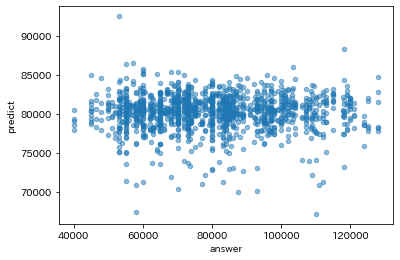

In [ ]:
result_df.plot.scatter(x='answer', y='predict', alpha=0.5)